# Зайцев Н. ПИ20-1В

<h1 align='center'> NLP с нуля: Классификация имен с помощью RNN на уровне символов

**Перевод статьи**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

Мы будем создавать и обучать RNN базового уровня для классификации
слов. В этом руководстве, наряду со следующими двумя, показано, как выполнить
предварительную обработку данных для моделирования NLP "с нуля", в частности, не используя
многие удобные функции `torchtext`, чтобы вы могли увидеть, как
предварительная обработка для моделирования NLP работает на низком уровне.

RNN на уровне символов считывает слова как серию символов, выводя предсказание и "скрытое состояние" на каждом шаге, передавая свое предыдущее скрытое состояние на каждый следующий шаг. Мы принимаем окончательное предсказание
за результат, т. е. к какому классу относится слово.

В частности, мы будем тренироваться на нескольких тысячах фамилий из 18 языков происхождения и предсказывать, с какого языка происходит имя, основываясь на написании:
::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Предварительное чтение:**

Предполагается что читатель установил PyTorch, знает Python, и понимает Tensors:

-  `https://pytorch.org/` для инструктажа по установке
-  :doc:`/beginner/deep_learning_60min_blitz` для начала основ PyTorch
-  :doc:`/beginner/pytorch_with_examples` для широкого обзора возможностей

Полезно также ознакомится с RNNs и тем как они работают:

-  <a href= https://karpathy.github.io/2015/05/21/rnn-effectiveness/>The Unreasonable Effectiveness of Recurrent Neural Networks </a> описывает примеров из реальной практики
-  <a href= https://colah.github.io/posts/2015-08-Understanding-LSTMs/>Understanding LSTM Networks </a> описывает LSTM, но также информирует об основах RNN. 

## Подготовка данных 

.. Примечание::
   Загрузите данные <a href=https://download.pytorch.org/tutorial/data.zip>отсюда</a> и извлеките их в текущую директорию.

В каталог `data/names` включены 18 текстовых файлов с именем `[Language].txt`. Каждый файл содержит кучу имен, по одному имени в строке, в основном латинизированных (но нам все равно нужно преобразовать из Юникода в
ASCII).

В итоге мы получим словарь со списками имен на каждом языке,`{language: [names ...]}`. Общие переменные `category` и `line`(для языка и имени в нашем случае) используются для последующего расширения.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


Теперь у нас есть `category_lines`, словарь, сопоставляющий каждую категорию (язык) со списком строк (имен). Мы также отслеживали `all_categories` (просто список языков) и `n_categories` для последующего использования.

In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Превращение имен в тензоры
--------------------------

Теперь, когда мы упорядочили все имена, нам нужно превратить их в
Тензоры, чтобы как-то их использовать.

Чтобы представить одну букву, мы используем `one-hot` вектор размера
`<1 x n_letters>`. Один горячий вектор заполняется 0, за исключением 1
в индексе текущей буквы, например `"b" = <0 1 0 0 0 ...>`.

Чтобы составить слово, мы объединяем их в 2D-матрицу
`<line_length x 1 x n_letters>`.

Это дополнительное измерение 1 связано с тем, что PyTorch предполагает, что все находится в пакетах - здесь мы просто используем размер пакета 1.

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Создание сети

Перед вычислением градиентов, создание рекуррентной нейронной сети в Torch включающей
клонирование параметров слоя в течение нескольких временных шагов. Слои
содержали скрытое состояние и градиенты, которые теперь полностью обрабатываются самим
графом. Это означает, что вы можете реализовать RNN очень "чистым" способом,
как обычные слои обратной связи.

Этот модуль RNN (в основном скопирован из учебника <a href=https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net> PyTorch for Torch users tutorial </a>) это всего лишь 2 линейных слоя, которые работают в входном и скрытом состоянии, со слоем LogSoftmax после вывода.

.. рисунок:: https://i.imgur.com/Z2xbySO.png
   :alt:


In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Чтобы запустить шаг этой сети, нам нужно передать входные данные (в нашем случае Тензор для текущей буквы) и предыдущее скрытое состояние (которое мы сначала инициализируем как нули). Мы вернем вывод (вероятность каждого языка) и следующее скрытое состояние (которое мы сохраняем для следующего шага).


In [5]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.8818, -2.9279, -2.9628, -2.8856, -2.8673, -2.9132, -2.9154, -2.8717,
         -2.8198, -3.0098, -2.8645, -2.8508, -2.8095, -2.8645, -2.9463, -2.8280,
         -2.8820, -2.9496]], grad_fn=<LogSoftmaxBackward0>)


Для повышения эффективности мы не хотим создавать новый тензор для каждого шага, поэтому мы будем использовать `lineToTensor` вместо `letterToTensor` и использовать срезы. Это может быть дополнительно оптимизировано путем
предварительного вычисления пакетов тензоров.

In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8818, -2.9279, -2.9628, -2.8856, -2.8673, -2.9132, -2.9154, -2.8717,
         -2.8198, -3.0098, -2.8645, -2.8508, -2.8095, -2.8645, -2.9463, -2.8280,
         -2.8820, -2.9496]], grad_fn=<LogSoftmaxBackward0>)


Как вы можете видеть, результат представляет собой тензор `<1 x n_categories>`, где
каждый элемент является вероятностью этой категории (чем выше, тем вероятнее).

## Обучение
Подготовка к обучению
----------------------

Прежде чем приступить к обучению, мы должны сделать несколько вспомогательных функций.
Первый - интерпретировать выходные данные сети, которые, как мы знаем, являются
вероятностью для каждой категории. Мы можем использовать `Tensor.topk`, чтобы получить индекс
наибольшего значения:

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 11)


Нам также понадобится быстрый способ получить обучающий пример (название и его
язык):

In [7]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Walentowicz
category = Dutch / line = Sevriens
category = Vietnamese / line = Lam
category = German / line = Stumpf
category = Irish / line = O'Keeffe
category = French / line = Leroy
category = Korean / line = Jon
category = Chinese / line = Xing
category = Korean / line = Jang
category = Spanish / line = Zubizarreta


Обучение сети
--------------------

Теперь все, что нужно для обучения этой сети, - это показать ей кучу примеров,
заставить ее строить догадки и сказать, ошибается ли она.

Для функции потерь подходит `nn.NLLLoss`, так как последний слой RNN - `nn.LogSoftmax`.


In [10]:
criterion = nn.NLLLoss()

Каждый цикл обучения будет делать:

- Создание входных и целевых тензоров
- Создание обнуленное начальное скрытое состояние
- Читать каждую букву и

   - Сохранять скрытое состояние для следующего текста

- Сравните конечный результат с целевым
- Обратное распространение
- Возврат выходных данных и значений функции ошибки

In [10]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Теперь нам просто нужно запустить это с кучей примеров. Поскольку функция
`train` возвращает как результат, так и список ошибки, мы можем распечатать ее
предсказание, а также отслеживатьошибку для построения графика. Поскольку существует 1000
примеров, мы печатаем только все примеры `print_every` и берем
среднее значение потерь.

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.5004 Braden / German ✗ (Irish)
10000 10% (0m 23s) 3.1414 Black / Czech ✗ (Scottish)
15000 15% (0m 35s) 2.1713 Nam / Chinese ✗ (Korean)
20000 20% (0m 50s) 1.7030 Kollen / Dutch ✓
25000 25% (0m 59s) 3.5792 Hahn / Vietnamese ✗ (German)
30000 30% (1m 7s) 1.0839 O'Hare / Irish ✓
35000 35% (1m 15s) 1.2350 Baklanoff / Russian ✓
40000 40% (1m 23s) 0.3873 Dinh / Vietnamese ✓
45000 45% (1m 29s) 1.2057 Oursler / German ✓
50000 50% (1m 36s) 4.0617 Murtas / Scottish ✗ (Italian)
55000 55% (1m 41s) 1.9500 Kolijn / Japanese ✗ (Dutch)
60000 60% (1m 47s) 0.0880 Kattan / Arabic ✓
65000 65% (1m 53s) 0.3612 Louverdis / Greek ✓
70000 70% (1m 59s) 0.0499 Thach / Vietnamese ✓
75000 75% (2m 4s) 2.5218 Marquering / Dutch ✗ (German)
80000 80% (2m 10s) 1.5960 Riedel / Dutch ✗ (Czech)
85000 85% (2m 16s) 2.4276 Bhrighde / Russian ✗ (Irish)
90000 90% (2m 21s) 1.9766 Franke / Polish ✗ (German)
95000 95% (2m 27s) 0.0983 Altoviti / Italian ✓
100000 100% (2m 32s) 1.0357 Machado / Portuguese ✓


Построение графика результатов
--------------------

Построение графика исторических потерь из `all_losses` показывает
обучение сети:

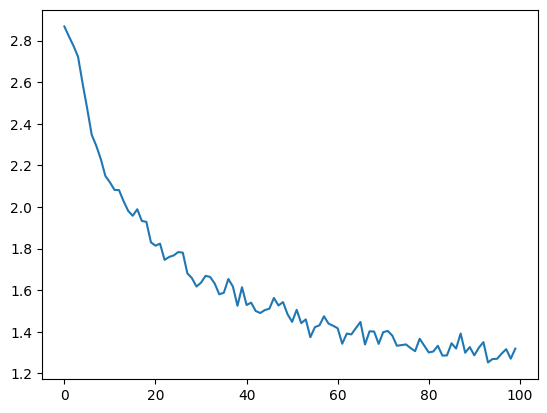

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Оценка результатов

Чтобы увидеть, насколько хорошо сеть работает с различными категориями, мы
создадим матрицу путаницы, указывающую для каждого фактического языка (строк)
какой язык угадывает сеть (столбцы). Чтобы рассчитать матрицу путаницы
, по сети выполняется множество выборок с
`evaluate()`, что то же самое, что `train()` за вычетом обратного распространения ошибки.


/var/folders/81/y47jjh9s7yzcqp46xzsyj5_00000gn/T/ipykernel_11302/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/81/y47jjh9s7yzcqp46xzsyj5_00000gn/T/ipykernel_11302/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


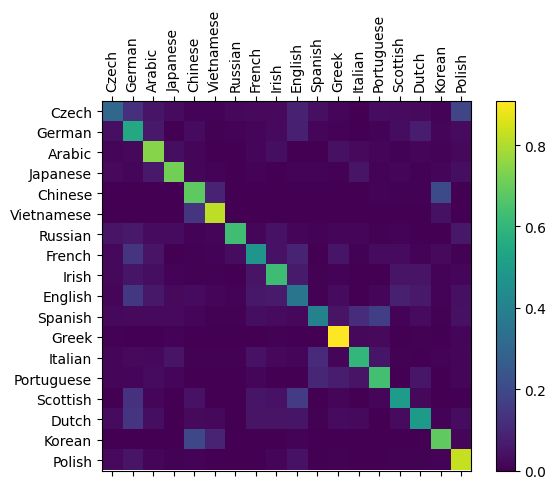

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Вы можете выделить яркие пятна на главной оси, которые показывают, какие языки он угадывает неправильно, например, китайский для корейского и испанский для итальянского. Похоже, он очень хорошо сочетается с греческим и очень плохо с английским (возможно, из-за совпадения с другими языками).

Запуск при вводе пользователем
-----

In [14]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.69) Czech
(-1.01) Russian
(-3.05) English

> Jackson
(-0.66) Scottish
(-1.11) English
(-2.68) Russian

> Satoshi
(-1.29) Arabic
(-1.52) Japanese
(-1.58) Polish


Упражнения
=========

- Попробуйте использовать другой набор данных строки -> категория, например:

   - Любое слово -> язык
   - Имя -> пол
   - Имя персонажа -> писатель
   - Заголовок страницы -> блог или субреддит

- Получите лучшие результаты с помощью более крупной и/или более совершенной сети

   - Добавьте больше линейных слоев
   - Попробуйте слои `nn.LSTM` и `nn.GRU` .
   - - Объедините несколько из этих запусков в сеть более высокого уровня


## Задание 1.
Добавить еще один нейронный слой nn.Linear() в модель. Выполнить предсказание на данных, сравнить точность предсказаний по разным языкам, используя горячую матрицу. 

In [15]:
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN1, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h1(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn1 = RNN1(n_letters, n_hidden, n_categories)



In [16]:
learning_rate = 0.005

def train1(category_tensor, line_tensor):
    hidden = rnn1.initHidden()

    rnn1.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn1(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn1.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [17]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train1(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.6337 Petrezelka / Spanish ✗ (Czech)
10000 10% (0m 28s) 2.0048 Kitchin / Irish ✗ (English)
15000 15% (0m 59s) 0.2326 Kasaya / Japanese ✓
20000 20% (1m 18s) 1.9576 Opova / Spanish ✗ (Czech)
25000 25% (1m 29s) 1.1964 Alescio / Spanish ✗ (Italian)
30000 30% (1m 41s) 3.0618 Giersig / Scottish ✗ (Czech)
35000 35% (1m 51s) 0.6829 Pan / Chinese ✓
40000 40% (2m 1s) 1.2905 Garcia / Spanish ✗ (Portuguese)
45000 45% (2m 14s) 2.1248 Favero / Portuguese ✗ (Italian)
50000 50% (2m 23s) 1.0996 O'Halloran / Irish ✓
55000 55% (2m 32s) 0.8558 Wasem / Arabic ✓
60000 60% (2m 41s) 7.2929 Melia / Spanish ✗ (English)
65000 65% (2m 50s) 2.1992 Gordon / Dutch ✗ (Scottish)
70000 70% (2m 59s) 0.2320 Ta / Vietnamese ✓
75000 75% (3m 9s) 2.2020 Rios / Portuguese ✗ (Spanish)
80000 80% (3m 17s) 2.8693 Barone / French ✗ (Italian)
85000 85% (3m 26s) 0.7722 Monet / French ✓
90000 90% (3m 35s) 0.9063 Simpson / Scottish ✓
95000 95% (3m 47s) 0.7539 Ferro / Portuguese ✓
100000 100% (3m 59s) 0.5968 Bach / Vi

/var/folders/81/y47jjh9s7yzcqp46xzsyj5_00000gn/T/ipykernel_11302/2033656587.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/81/y47jjh9s7yzcqp46xzsyj5_00000gn/T/ipykernel_11302/2033656587.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


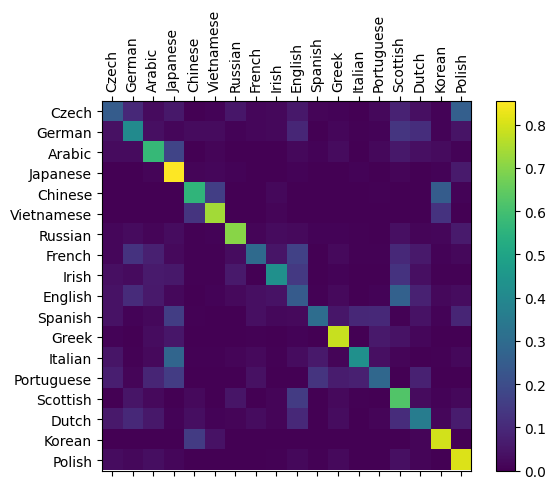

In [18]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn1.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn1(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Задание 2.
Добавьте в модель слой nn.LSTM() посмотрите влияние его на матрицу неточностей.

In [4]:
import torch
import torch.nn as nn

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.i2h = nn.Linear(hidden_size, hidden_size)
        self.i2h1 = nn.Linear(hidden_size + input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        lstm_out, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = lstm_out.view(1, -1)
        hidden_state, cell_state = hidden  
        hidden_state = hidden_state.view(1, 1, -1)  
        hidden_state = self.i2h(hidden_state)
        combined = torch.cat((input.view(1, -1), hidden_state.view(1, -1)), 1)  
        hidden_state = self.i2h1(combined)
        output = self.i2o(hidden_state)
        output = self.softmax(output)
        hidden = (hidden_state.view(1, 1, -1), cell_state) 
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

n_hidden = 128
rnn2 = RNN2(n_letters, n_hidden, n_categories)

In [5]:
learning_rate = 0.001

def train2(category_tensor, line_tensor):
    hidden = rnn2.initHidden()

    rnn2.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn2(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn2.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train2(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 34s) 0.8629 Teshima / Japanese ✓
10000 10% (1m 10s) 1.1398 Filipek / Polish ✓
15000 15% (1m 45s) 5.9239 Padovan / Irish ✗ (Italian)
20000 20% (2m 21s) 1.1683 Quach / Vietnamese ✓
25000 25% (2m 56s) 1.2952 Chang / Chinese ✗ (Korean)
30000 30% (3m 31s) 2.2799 Harman / Irish ✗ (French)
35000 35% (4m 0s) 2.0879 Horn / Irish ✗ (Dutch)
40000 40% (4m 27s) 1.5133 Roach / Irish ✓
45000 45% (4m 55s) 1.3619 Tighearnach / Irish ✓
50000 50% (5m 23s) 1.4741 Le / Chinese ✗ (Vietnamese)
55000 55% (5m 50s) 1.3911 Lane / French ✓
60000 60% (6m 18s) 3.8777 Roldan / Scottish ✗ (Spanish)
65000 65% (6m 46s) 0.8878 Mo / Korean ✓
70000 70% (7m 14s) 2.0362 Bell / Dutch ✗ (English)
75000 75% (7m 41s) 1.3334 Sortras / Portuguese ✗ (Greek)
80000 80% (8m 9s) 0.7111 Yoo / Korean ✓
85000 85% (8m 37s) 0.2218 Gomatos / Greek ✓
90000 90% (38m 49s) 0.0185 Grokhov / Russian ✓
95000 95% (39m 25s) 2.0689 Hill / Czech ✗ (Scottish)
100000 100% (39m 54s) 0.5966 Melendez / Spanish ✓


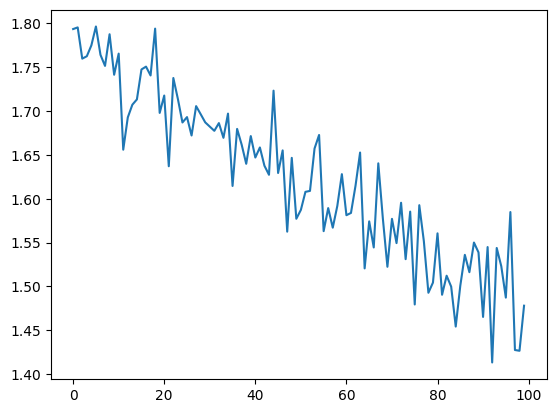

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/var/folders/81/y47jjh9s7yzcqp46xzsyj5_00000gn/T/ipykernel_11618/2295856914.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/81/y47jjh9s7yzcqp46xzsyj5_00000gn/T/ipykernel_11618/2295856914.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


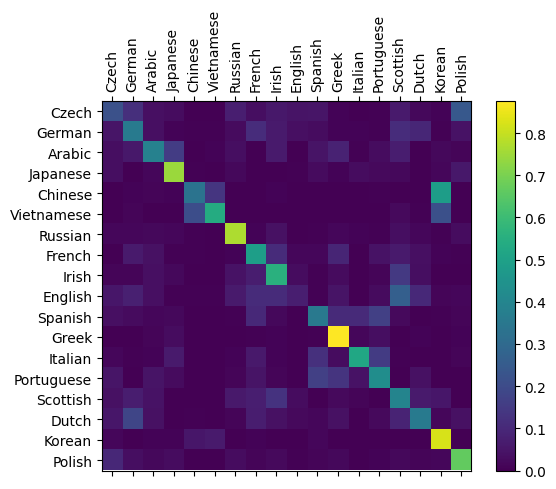

In [18]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn2.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn2(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()